# **Лабораторная работа №5**
## **Кластеризация**
## **Вариант 6: Клиенты магазина**

**Цель работы**: изучение принципов решения задачи многомерной регрессии с использованием методов машинного обучения на языке Python.

Набор данных содержит сведения о клиентах магазина, и к этим историческим данным необходимо применить сегментацию клиентов — процесс разбиения клиентской базы на группы с похожими характеристиками, что позволяет бизнесу более точно нацеливать маркетинговые усилия и распределять ресурсы; например, одна группа может включать клиентов с высоким доходом и высокой оценкой расходов, которых важно удерживать и стимулировать их лояльность, а другая — клиентов с меньшей активностью покупок, для которых целью является повышение вовлеченности через специальные предложения.

Набор данных включает следующие атрибуты:
*   Customer ID – идентификатор клиента.
*   Gender – пол клиента.
*   Age – возраст клиента в годах.
*   Annual Income – годовой доход клиента.
*   Spending Score – оценка расходов, присваиваемая магазином на основе поведения покупателя и характера расходов.
*   Work Experience – опыт работы в годах.
*   Family Size – размер семьи.
*   Profession – профессия




## Импортируем библиотеки и загружаем данные

In [146]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv('Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## Получим информацию о датасете

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


## Проверяем данные на наличие пропущенных значений и выбросов

In [148]:
print(df.isnull().sum())

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64


## Заполняем пропуски

In [149]:
df_copy = df.copy()
# Заполняем пропуски в столбце Profession значением 'Unknown'
df_copy['Profession'] = df_copy['Profession'].fillna(df_copy['Profession'].mode()[0])
df_copy['Profession'].isna().sum()


np.int64(0)

In [150]:
for col in ['Gender', 'Profession']:
    unique, counts = np.unique(df_copy[col], return_counts=True)
    print(f'Unique values of {col}: {unique}')
    print(f'Counts: {counts}\n')

Unique values of Gender: ['Female' 'Male']
Counts: [1186  814]

Unique values of Profession: ['Artist' 'Doctor' 'Engineer' 'Entertainment' 'Executive' 'Healthcare'
 'Homemaker' 'Lawyer' 'Marketing']
Counts: [647 161 179 234 153 339  60 142  85]



In [151]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_copy['Gender'] = labelencoder.fit_transform(df_copy['Gender'])
df_copy['Profession'] = labelencoder.fit_transform(df_copy['Profession'])
df_copy.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,1,19,15000,39,5,1,4
1,2,1,21,35000,81,2,3,3
2,3,0,20,86000,6,2,1,1
3,4,0,23,59000,77,7,0,2
4,5,0,31,38000,40,3,2,6


## Исключаем невлияющие категориальные признаки

In [152]:
y = df_copy['CustomerID']
df_copy.drop('CustomerID', axis = 1, inplace = True)
df_copy.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,19,15000,39,5,1,4
1,1,21,35000,81,2,3,3
2,0,20,86000,6,2,1,1
3,0,23,59000,77,7,0,2
4,0,31,38000,40,3,2,6


## Применяем операцию нормализации для численной устойчивости

In [153]:
# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

## Приведем данные к единому масштабу

In [154]:
X = scaler.fit_transform(df_copy)
print(X[:4,:])

[[ 1.20706357 -1.05408932 -2.09350095 -0.42833854  0.87049473 -0.79120713
   0.11749744]
 [ 1.20706357 -0.98372287 -1.65613312  1.07554599 -0.30637962 -0.28116224
  -0.39005088]
 [-0.82845678 -1.0189061  -0.54084515 -1.6099621  -0.30637962 -0.79120713
  -1.40514752]
 [-0.82845678 -0.91335643 -1.13129172  0.93231889  1.65507763 -1.04622958
  -0.8975992 ]]


## Определяем оптимальное количество кластеров с помощью метода локтя

In [155]:
from sklearn.cluster import KMeans

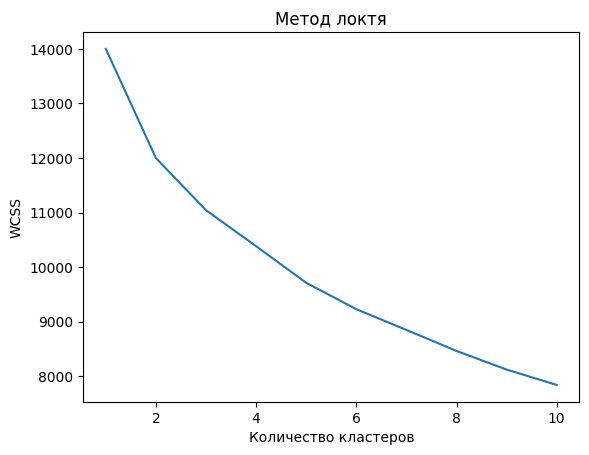

In [156]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

## Обучаем модель кластеризации

In [157]:
# создаем экземпляр модели с 3 кластерами
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
# обучаем модель на стандартизированных данных
kmeans.fit(X)


KMeans(n_clusters=3, random_state=42)

## Предсказываем кластеры и визуализируем результаты

In [158]:
# предсказываем кластеры для каждого
clusters = kmeans.predict(X)
# добавляем метки кластеров в исходные данные
df_copy['cluster'] = clusters
df_copy.head()


,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,cluster
0,1,19,15000,39,5,1,4,0
1,1,21,35000,81,2,3,3,0
2,0,20,86000,6,2,1,1,1
3,0,23,59000,77,7,0,2,1
4,0,31,38000,40,3,2,6,2


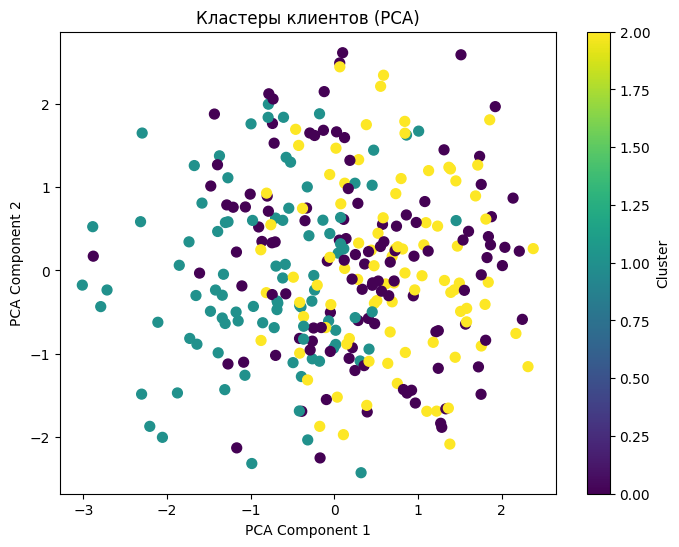

In [164]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ограничиваем количество точек для визуализации
sample_size = 300
if X_pca.shape[0] > sample_size:
    indices = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
else:
    indices = np.arange(X_pca.shape[0])

# Построение графика
plt.figure(figsize=(8,6))
plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=clusters[indices], cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Кластеры клиентов (PCA)')
plt.colorbar(label='Cluster')
plt.show()

In [165]:
# Группируем по кластерам
cluster_groups = df_copy.groupby('cluster')
# Анализ средних значений в каждом кластере
cluster_groups.mean()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,CustomerID
cluster,,,,,,,,
0,1.0,49.159705,110991.323096,50.944717,2.800983,4.200246,3.769042,1003.649877
1,0.0,45.774760,98844.667732,48.835463,2.722045,3.623003,2.210863,863.346645
2,0.0,52.230357,123642.757143,53.366071,2.817857,4.496429,5.508929,1149.239286


## Интерпретация результатов

* Кластер 0: мужчины, высокий доход, средние расходы.

* Кластер 1: женщины, самый высокий доход, средние расходы.

* Кластер 2: женщины старшего возраста, умеренный доход, чуть более активные расходы.

In [161]:
# Добавим айди клиентов в исходные данные
df_copy['CustomerID'] = y
df_copy.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,cluster,CustomerID
0,1,19,15000,39,5,1,4,0,1
1,1,21,35000,81,2,3,3,0,2
2,0,20,86000,6,2,1,1,1,3
3,0,23,59000,77,7,0,2,1,4
4,0,31,38000,40,3,2,6,2,5


In [162]:
# Вывод айди клиентов в каждом кластере
for cluster_num in range(3):
  print(f"\nCluster {cluster_num} IDs:")
  print(df_copy[df_copy['cluster'] == cluster_num]['CustomerID'].values)


Cluster 0 IDs:
[   1    2    9   11   15   16   18   19   21   22   24   26   28   31
   33   34   42   43   52   54   56   58   60   61   62   65   66   69
   71   75   76   78   81   82   83   86   92   93   96   99  100  103
  104  105  108  109  110  111  114  121  124  127  128  129  130  131
  132  135  138  139  142  145  146  147  150  151  152  157  159  163
  165  167  170  171  172  173  174  177  178  179  180  183  186  188
  193  198  199  200  202  208  213  214  215  217  223  228  229  230
  232  237  238  239  241  247  251  256  257  258  260  266  271  276
  277  278  280  286  291  293  298  299  300  301  302  309  311  315
  316  318  319  321  322  324  326  328  331  333  334  342  343  352
  354  356  358  360  361  362  365  366  369  371  375  376  378  381
  382  383  386  392  393  396  399  400  403  404  405  408  409  410
  411  414  421  424  427  428  429  430  431  432  435  438  439  442
  445  446  447  450  451  452  457  459  463  465  467  470 